
# Notebook 3: From Blueprint to Factory — Training Transolver

Welcome to the final notebook in our series!

* In **Notebook 1 ("The Why")**, we established the core problem: standard Transformers have a "quadratic complexity" ($O(N^2)$). This makes them "computationally prohibited" for the "large-scale meshes" used in real-world physics. We saw that physics is mostly local, making this all-to-all attention incredibly wasteful.

* In **Notebook 2 ("The How")**, we built a `NumPy` blueprint of the Transolver solution: **Physics-Attention**. We saw the 4-step mathematical process (Slice, Aggregate, Attend, Deslice) that breaks the quadratic bottleneck and achieves **linear complexity** ($O(N)$).

### **The Goal of This Notebook**

Our goal is to use **PhysicsNeMo** training pipeline to train the **Transolver model** on our **Ahmed body simulations**.

This notebook is a "guided tour" of this pipeline. We will see how all the `.py` scripts you have (`datapipe.py`, `train.py`, etc.) in PhysicsNeMo for Transolver work together [Transolver src in PhysicsNeMo GitHub repository](https://github.com/NVIDIA/physicsnemo/tree/main/examples/cfd/external_aerodynamics/transolver/src).

**Note on Training Scope:** For this educational demonstration, we will execute training for only a few epochs to validate the integrity of the pipeline. For a high-fidelity, production-level run, we recommend utilizing the full Transolver recipe available in the [PhysicsNeMo GitHub repository](https://github.com/NVIDIA/physicsnemo/tree/main/examples/cfd/external_aerodynamics/transolver).


### The Workflow: A 3-Stage Process

We will follow a 3-stage process to go from raw VTP/STL files to a trained model.

**Stage 1: Preprocessing (VTP/STL $\to$ Zarr)**
* **The Problem:** The high-performance `datapipe.py` script is a `ZarrDataset` reader. It does *not* know how to read your VTP/STL files.
* **Our Solution:** We will first run a script that loops through all 508 of our VTP/STL files. This script will:
    1.  Read each VTP/STL pair.
    2.  Extract all the arrays the model needs (e.g., `surface_mesh_centers`, `surface_normals`, `surface_fields`).
    3.  Save them in the efficient `.zarr` format.
* We will also split our 508 files into a `train` set (~457 files) and a `val` set (~51 files) so we can check for overfitting.

**Stage 2: Normalization (`compute_normalizations.py`)**
* **The Problem:** Our target data, `surface_fields`, contains both **pressure** and **wall shear stress**. These have vastly different scales (e.g., 1000 Pa vs. 0.5 $N/m^2$). If we don't fix this, the model will only learn to predict the "loud" pressure data and will ignore the "quiet" WSS.
* **The Solution:** We will run a script that loops through our new `train` Zarr dataset and computes the global **mean** and **standard deviation** for our target fields. This saves a `surface_fields_normalization.npz` file, which `train.py` uses to "z-score" the targets, ensuring the model gives them equal importance.

**Stage 3: Training (`train.py`)**
* **This is the main event.** We will adapt the `train.py` script to run in this notebook. This "factory manager" script does the following every step:
    1.  Uses `datapipe.py` to efficiently load a Zarr file.
    2.  Uses `preprocess.py` to prepare the data (e.g., center the car, normalize the targets using our `.npz` file).
    3.  Performs the **forward pass** by sending the data through the `Transolver` model.
    4.  Uses `loss.py` to calculate the error (the "loss").
    5.  Performs the **backward pass** (learning) and updates the model's weights.
    6.  Uses `metrics.py` to calculate human-readable L2 errors on the *un-normalized* data so we can see how well it's *really* doing.

### What Is the Model *Really* Learning?

As we run the training, remember the core idea from the Transolver paper. We are not just fitting points. We are training the model to move beyond the "superficial and unwieldy meshes".

The model is learning to:
1.  **"Ascribe"** all the mesh points into $M$ "learnable slices".
2.  **Discover** the "intrinsic physical states" of the flow, grouping physically similar points.
3.  **Learn** to group spatially distant but physically-related points, like the **windshield, license plate, and headlight**, into the same "front-facing" slice.

This is what gives Transolver its power. Let's begin.


---
## **Library Imports**
The code block below is the main setup cell, responsible for importing all the necessary tools for the notebook. It's divided into several groups: standard Python libraries (os, glob, random) for file finding and shuffling; core data science and machine learning libraries (numpy, torch, torchinfo) for handling data and building the neural network; specialized simulation libraries (pyvista, zarr, tqdm) for reading your 3D VTP/STL files, writing them to the efficient Zarr format, and displaying progress bars; and performance utilities (torch.amp, tabulate) for speeding up training and printing clean results.

The most critical section is the try...except block, which imports the actual Transolver model from the physicsnemo library and all the custom Python scripts (datapipe.py, loss.py, etc.) that define our training pipeline. This block ensures all necessary code is present before we begin. Finally, the cell sets random seeds (np.random.seed(42)) to make our training reproducible, and it configures pyvista with a "virtual screen" (pv.start_xvfb()) so it can process 3D meshes in a headless server environment like this notebook.

In [1]:
import os
import glob
import random
import time
from pathlib import Path

# Core ML/Data Libraries
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.amp import autocast, GradScaler
from tabulate import tabulate
import torchinfo

# Visualization & VTP/STL Reading
import pyvista as pv
import zarr
from tqdm import tqdm
from IPython.display import Markdown as md, display
#  Physics-NEMO Imports
try:
    from physicsnemo.models.transolver import Transolver
    from physicsnemo.distributed import DistributedManager
    from physicsnemo.launch.logging import PythonLogger, RankZeroLoggingWrapper
    
# Import from the 'utils' directory
    from utils.datapipe import DomainParallelZarrDataset
    from utils.loss import loss_fn
    from utils.metrics import metrics_fn
    from utils.preprocess import preprocess_surface_data, downsample_surface
    from utils.compute_normalizations import compute_mean_std_min_max
   
except ImportError as e:
    print("="*50)
    print("ERROR: Could not import Physics-NEMO files.")
    print("Please ensure physicsnemo is installed and all .py scripts")
    print("(datapipe.py, loss.py, etc.) are in the same directory as this notebook.")
    print(f"Details: {e}")
    print("="*50)
    # This will stop the notebook if imports fail
    raise e

# Set consistent random seeds
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

# Setup for PyVista plotting in a headless environment
pv.start_xvfb()
os.environ["XDG_RUNTIME_DIR"] = "/tmp"

/usr/local/lib/python3.12/dist-packages/pyvista/plotting/utilities/xvfb.py:48: PyVistaDeprecationWarning: This function is deprecated and will be removed in future version of PyVista. Use vtk-osmesa instead.
  warnings.warn(


---
## **Configuration**

This first cell is the most important one for you to edit. It acts as the central **"control panel"** for the entire notebook. You must set all the paths and parameters here before running any other part.

Here is a breakdown of what each section does:

* **1. Data Input Paths (`VTP_DIR`, `STL_DIR`):**
    * This tells the notebook where to **find** your 508 raw simulation files.
    * `VTP_DIR` points to the folder containing your `.vtp` files (which have the pressure and wall shear stress data).
    * `STL_DIR` points to the folder containing your `.stl` files (which have the base geometry).

* **2. Data Output Paths (`ZARR_OUTPUT_DIR`, `CHECKPOINT_DIR`, `LOG_DIR`):**
    * This tells the notebook where to **save** all the new files it creates.
    * `ZARR_OUTPUT_DIR` is the main folder where the script will save the processed `.zarr` files. Zarr is a high-performance format that the `datapipe.py` script knows how to read quickly during training.
    * `CHECKPOINT_DIR` is where the trained model files (your `.pt` or `.pth` files) will be saved after each epoch.
    * `LOG_DIR` is where data for TensorBoard (a tool for visualizing training loss) will be stored.

* **3. Splitting (`TRAIN_SPLIT_RATIO`):**
    * This is a crucial machine learning step. We can't train and test the model on the same data.
    * This line splits your 508 files into two groups:
        * **Training Set (90%, ~457 files):** The data the model *learns* from.
        * **Validation Set (10%, ~51 files):** The data the model is *tested* on to see if it's *actually* learning the physics or just "memorizing" the training files.

* **4. Simulation Parameters (`AIR_DENSITY`, `STREAM_VELOCITY`):**
    * These are **critical inputs** that are *not* in your VTP/STL files.
    * The model needs to know the physical conditions of the simulation. These are "functional features" that are fed into the model along with the geometry.
    * You must set these to the correct constant values used in your simulations.

* **5. Model & Training Hyperparameters (`C_MODEL`, `M_SLICES`, etc.):**
    * These variables define the **architecture of the Transolver model** and the **training plan**.
    * `C_MODEL` (`n_hidden` in the Transolver paper ) sets the feature size inside the model.
    * `M_SLICES` (`slice_num` in the Transolver paper) sets the number of "physics-aware slices" ($M$)—the core idea of Transolver.
    * `NUM_LAYERS` and `NUM_HEADS` define the depth and width of the Transformer.
    * `NUM_EPOCHS = 5` is set low *specifically for this educational notebook* so it runs quickly. A real training run would use hundreds of epochs.

* **Final Section (`os.makedirs`):**
    * This is a "housekeeping" step. It automatically creates the `train/`, `val/`, and `checkpoints/` directories you defined in Section 2.
    * This ensures the script doesn't crash later when it tries to save a file to a folder that doesn't exist.

In [2]:
# 1. Data Input Paths
# Point this to the directory containing your 508 VTP files
VTP_DIR = "/workspace/physicsnemo_ahmed_body_dataset_vv1/dataset/train"
# Point this to the directory containing your 508 STL files
STL_DIR = "/workspace/physicsnemo_ahmed_body_dataset_vv1/dataset/train_stl_files"

# 2. Data Output Paths
# This is where all the processed Zarr files will be saved
ZARR_OUTPUT_DIR = "/workspace/physicsnemo_ahmed_body_dataset_vv1/dataset/ahmed_body_zarr"
# This is where the final model checkpoints will be saved
CHECKPOINT_DIR = "./checkpoints/"
# This is where TensorBoard logs will be saved
LOG_DIR = "./logs/"

# 3. Splitting
# We will split your 508 files into a training and validation set
# 0.9 = 90% for training (~457 files), 10% for validation (~51 files)
TRAIN_SPLIT_RATIO = 0.9

# 4. Simulation Parameters
# The model NEEDS these. You must provide the *correct* values
AIR_DENSITY = 1.184
STREAM_VELOCITY = 25.0

# 5. Model & Training Hyperparameters
# These are small for a fast "educational" run.
# For a real run, use the values from the paper (e.g., 512, 12, 8)
C_MODEL = 64   # Feature dimension (transolver paper uses 512)
M_SLICES = 16  # Number of slices (transolver paper uses 64)
NUM_LAYERS = 4 # Number of layers (transolver paper uses 12)
NUM_HEADS = 4  # Number of attention heads (transolver paper uses 8)
NUM_EPOCHS = 5 # Run for just 5 epochs
PRECISION = "float32" # "float16" or "bfloat16" for faster training
LEARNING_RATE = 1e-4


# Create all the output directories
# These are the directories the training script expects
TRAIN_ZARR_DIR = os.path.join(ZARR_OUTPUT_DIR, "train")
VAL_ZARR_DIR = os.path.join(ZARR_OUTPUT_DIR, "val")
CHECKPOINT_PATH = os.path.join(CHECKPOINT_DIR, "ahmed_body_run")
LOG_PATH = os.path.join(LOG_DIR, "ahmed_body_run")

os.makedirs(TRAIN_ZARR_DIR, exist_ok=True)
os.makedirs(VAL_ZARR_DIR, exist_ok=True)
os.makedirs(CHECKPOINT_PATH, exist_ok=True)
os.makedirs(LOG_PATH, exist_ok=True)

print("--- Configuration Loaded ---")
print(f"Training Zarr Path: {TRAIN_ZARR_DIR}")
print(f"Validation Zarr Path: {VAL_ZARR_DIR}")
print(f"Checkpoint Path: {CHECKPOINT_PATH}")

--- Configuration Loaded ---
Training Zarr Path: /workspace/physicsnemo_ahmed_body_dataset_vv1/dataset/ahmed_body_zarr/train
Validation Zarr Path: /workspace/physicsnemo_ahmed_body_dataset_vv1/dataset/ahmed_body_zarr/val
Checkpoint Path: ./checkpoints/ahmed_body_run


---
## **Preprocessing (VTP/STL -> Zarr)**
This code block is the crucial preprocessing step (Stage 1), responsible for converting your 508 raw VTP/STL files into the efficient Zarr format that the PhysicsNeMo datapipe requires. The main loop at the bottom of the script acts as the "manager": it first finds and matches all 508 of your VTP and STL file pairs, shuffles them randomly to prevent bias, and then splits them into a training set (90% of the data) and a validation set (10%). It then uses tqdm to show a progress bar as it iterates through these two new lists, passing each file pair to the process_one_simulation function, which saves the converted files into the `TRAIN_ZARR_DIR` and `VAL_ZARR_DIR` folders you defined in Part 1.

The process_one_simulation function is the "worker" that handles the actual conversion for each simulation. It uses `pyvista` to open both files: from the `STL` file, it extracts cell-based geometry data (the `stl_areas` and `stl_centers` for each triangle), which the model uses later to find the center of mass. From the `VTP` file, it extracts the critical point-based data that the model actually trains on: the 3D coordinates (`surface_mesh_centers`), the normal vector for each point (`surface_normals`), and the target physics values (`pressure` and `wallShearStress`). It then stacks the pressure and WSS into a single surface_fields array and saves all these extracted arrays—plus the scalar air_density and stream_velocity—into a new, single `.zarr` file using the root.create_array command.

In [3]:
def process_one_simulation(stl_path, vtp_path, zarr_path, density, velocity):
    """
    Loads one VTP/STL pair, extracts data, and saves to a Zarr file.
    """
    try:
        # 1. PROCESS STL FILE
        stl_mesh = pv.get_reader(stl_path).read()
        
        # Explicitly compute cell sizes for area
        stl_areas_data = stl_mesh.compute_cell_sizes(length=False, area=True, volume=False)
        stl_areas = np.array(stl_areas_data.cell_data["Area"])
        
        # Call cell_centers() as a function
        stl_centers = stl_mesh.cell_centers().points
        
        if stl_areas.shape[0] == 0 or stl_centers.shape[0] == 0:
            raise ValueError(f"STL file {stl_path} is empty.")
            
        #  2. PROCESS VTP FILE (POINT-BASED WORKFLOW)
        vtp_mesh = pv.read(vtp_path)
        
        # Get POINT coordinates (N_points, 3)
        surface_mesh_centers = vtp_mesh.points
        
        # Compute POINT normals
        vtp_mesh.compute_normals(cell_normals=False, point_normals=True, 
                                 auto_orient_normals=True)
        
        # Access the .point_normals property
        surface_normals = vtp_mesh.point_normals
        
        # Check for our target POINT data keys
        if 'p' not in vtp_mesh.point_data or 'wallShearStress' not in vtp_mesh.point_data:
            print(f"Warning: VTP file {vtp_path} missing POINT data 'p' or 'wallShearStress'. "
                  f"Skipping. Keys: {vtp_mesh.array_names}")
            return False
            
        # Get POINT fields (N_points, 1) and (N_points, 3)
        pressure = vtp_mesh.point_data['p']
        wss = vtp_mesh.point_data['wallShearStress']
        
        # Reshape to (N, 1) and (N, 3)
        if pressure.ndim == 1:
            pressure = pressure.reshape(-1, 1)
        if wss.ndim == 1 or wss.shape[1] != 3:
            raise ValueError(f"wallShearStress shape is {wss.shape}, but (N, 3) is required.")
            
        # Stack to (N_points, 4) -> (Pressure, WSS_x, WSS_y, WSS_z)
        surface_fields = np.hstack((pressure, wss)).astype(np.float32)

        # 3. SAVE TO ZARR FILE
        root = zarr.open_group(zarr_path, mode='w')
        
        # --- FIX: Removed the extra batch dimension [None, ...] ---
        # The datapipe will add the batch dimension.
        # Save data as (N_points, C) or (N_cells, C)
        root.create_array('surface_mesh_centers', data=surface_mesh_centers, 
                            chunks=(10000, 3))
        root.create_array('surface_normals', data=surface_normals, 
                            chunks=(10000, 3))
        root.create_array('surface_fields', data=surface_fields, 
                            chunks=(10000, 4))
        
        # STL data is (N_cells, ...)
        root.create_array('stl_areas', data=stl_areas, 
                            chunks=(10000,))
        root.create_array('stl_centers', data=stl_centers, 
                            chunks=(10000, 3))
        
        # Scalar parameters
        root.create_array('air_density', data=np.array([density], dtype=np.float32))
        root.create_array('stream_velocity', data=np.array([velocity], dtype=np.float32))
        
        return True

    except Exception as e:
        print(f"Error processing {vtp_path}: {e}")
        return False

# Main Preprocessing Loop
print("--- PREPROCESSING ---")

# Find all VTP/STL files
vtp_files = sorted(glob.glob(os.path.join(VTP_DIR, "*.vtp")))
stl_files = sorted(glob.glob(os.path.join(STL_DIR, "*.stl")))

if len(vtp_files) == 0 or len(vtp_files) != len(stl_files):
    raise FileNotFoundError(f"Found {len(vtp_files)} VTP files and {len(stl_files)} STL files. "
                           "Paths may be wrong, or counts mismatch.")

print(f"Found {len(vtp_files)} matching VTP/STL simulation pairs.")

# Zip them together and shuffle
file_pairs = list(zip(stl_files, vtp_files))
random.shuffle(file_pairs)

# Split into train and val
split_index = int(len(file_pairs) * TRAIN_SPLIT_RATIO)
train_files = file_pairs[:split_index]
val_files = file_pairs[split_index:]

print(f"Splitting data: {len(train_files)} training, {len(val_files)} validation.")

# Process Training Files
print("\nProcessing TRAINING files...")
for i, (stl_path, vtp_path) in enumerate(tqdm(train_files, desc="Train Convert")):
    # sim_000.stl -> sim_000.zarr
    file_name = os.path.basename(stl_path).replace(".stl", ".zarr")
    zarr_path = os.path.join(TRAIN_ZARR_DIR, file_name)
    process_one_simulation(stl_path, vtp_path, zarr_path, AIR_DENSITY, STREAM_VELOCITY)

# Process Validation Files
print("\nProcessing VALIDATION files...")
for i, (stl_path, vtp_path) in enumerate(tqdm(val_files, desc="Val Convert")):
    file_name = os.path.basename(stl_path).replace(".stl", ".zarr")
    zarr_path = os.path.join(VAL_ZARR_DIR, file_name)
    process_one_simulation(stl_path, vtp_path, zarr_path, AIR_DENSITY, STREAM_VELOCITY)
    
print("\n--- Preprocessing COMPLETE ---")

--- STAGE 1: PREPROCESSING ---
Found 408 matching VTP/STL simulation pairs.
Splitting data: 367 training, 41 validation.

Processing TRAINING files...


Train Convert: 100%|██████████| 367/367 [02:24<00:00,  2.55it/s]



Processing VALIDATION files...


Val Convert: 100%|██████████| 41/41 [00:16<00:00,  2.47it/s]


--- STAGE 1: COMPLETE ---


---
## **Data Normalization**

The primary goal of this stage is to compute the statistical distribution of our target variables and generate the `surface_fields_normalization.npz` file. This file is a mandatory requirement for the training script to scale the physics outputs correctly.

### Objective: Balancing the Physics
Our target data (`surface_fields`) contains two very different physical quantities:
1.  **Pressure ($p$):** Often ranges in hundreds or thousands of Pascals.
2.  **Wall Shear Stress ($WSS$):** Typically ranges from 0.01 to 5.0.

Without normalization, the "louder" pressure values would dominate the model's loss function, causing it to ignore the smaller shear stress values. By calculating the **Mean** and **Standard Deviation** for each of the 4 output channels, we can perform "Z-score" normalization, putting all physical quantities on a level playing field so the model can learn both simultaneously.


### Implementation Strategy
* **Environment Configuration:** We manually set `WORLD_SIZE="1"` and `RANK="0"` to force the data loader into single-process mode, bypassing multi-GPU distributed checks.
* **Welford’s Algorithm:** To prevent memory overflow (OOM), we do not load all 400+ samples at once. Instead, we iterate through the training set one file at a time, updating the global mean and variance accumulators using a numerically stable, running calculation.
* **Leakage Prevention:** Statistics are computed **strictly on the training set**. We exclude validation data to ensure our final accuracy metrics remain untainted and objective.

> **Final Output:** The generated `.npz` file serves as the "scaling key." During training, it allows the model to map raw network outputs back into physically meaningful pressure and shear stress values.


In [18]:
# ===============================================================
# Normalization
# ===============================================================
print("--- COMPUTING NORMALIZATION ---")


import os
os.environ["RANK"] = f"0"
os.environ["WORLD_SIZE"] = f"1"
os.environ["MASTER_ADDR"] = "localhost"
os.environ["MASTER_PORT"] = str(12356)
os.environ["LOCAL_RANK"] = f"0"

from tqdm import tqdm

# We only need a *minimal* datapipe for this step.
norm_dataset = DomainParallelZarrDataset(
    data_path=TRAIN_ZARR_DIR,
    device_mesh=None,
    placements=None,
    max_workers=4,
    pin_memory=False,
    keys_to_read=['surface_fields'],
    large_keys=['surface_fields'],
)

# compute_mean_std_min_max_with_progress
# We re-implement the function from utils/compute_normalizations.py
# here so we can add a tqdm progress bar.

def compute_mean_std_min_max_with_progress(
    dataset: DomainParallelZarrDataset, field_key: str
) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Compute the mean, standard deviation, minimum, and maximum for a specified field
    across all samples in a dataset. (with tqdm progress bar)
    """
    N = 0  # Total number of elements processed
    mean = None
    M2 = None  # Sum of squares of differences from the current mean
    min_val = None
    max_val = None

    for i in tqdm(range(len(dataset)), desc="Computing Norms"):
        data = dataset[i][field_key]
        if mean is None:
            # Initialize accumulators based on the shape of the data
            mean = torch.zeros(data.shape[-1], device=data.device)
            M2 = torch.zeros(data.shape[-1], device=data.device)
            min_val = torch.full((data.shape[-1],), float("inf"), device=data.device)
            max_val = torch.full((data.shape[-1],), float("-inf"), device=data.device)
        
        # This part of the original script was incorrect, n was unused
        # n = data.shape[1]
        # N += n 
        
        # Compute batch statistics
        batch_mean = data.mean(axis=(0, 1))
        batch_M2 = ((data - batch_mean) ** 2).sum(axis=(0, 1))
        batch_n = data.shape[1] # This is the correct n

        # Update min/max
        batch_min = data.amin(dim=(0, 1))
        batch_max = data.amax(dim=(0, 1))
        min_val = torch.minimum(min_val, batch_min)
        max_val = torch.maximum(max_val, batch_max)

        # Update running mean and M2 (Welford's algorithm)
        delta = batch_mean - mean
        N_old = N # Store old N
        N += batch_n
        mean = mean + delta * (batch_n / N)
        M2 = M2 + batch_M2 + delta**2 * (batch_n * N_old) / N # Corrected Welford's

    var = M2 / (N - 1)
    std = torch.sqrt(var)
    return mean, std, min_val, max_val

# This runs our new function with the progress bar
mean, std, min_val, max_val = compute_mean_std_min_max_with_progress(norm_dataset, 'surface_fields')

print(f"Computed Mean: {mean.cpu().numpy()}")
print(f"Computed Std: {std.cpu().numpy()}")

# Save the statistics to the .npz file that train.py expects
norm_file_path = "surface_fields_normalization.npz"
np.savez(
    norm_file_path,
    mean=mean.cpu().numpy(),
    std=std.cpu().numpy(),
    min=min_val.cpu().numpy(),
    max=max_val.cpu().numpy(),
)

print(f"\nSuccessfully saved normalization file to: {norm_file_path}")
print("--- COMPLETE ---")

--- COMPUTING NORMALIZATION ---


Computing Norms: 100%|██████████| 367/367 [00:03<00:00, 109.50it/s]

Computed Mean: [-1.7354057e+02 -2.4689510e+00 -2.1376118e-01 -4.7654234e-02]
Computed Std: [346.60336     2.1168454   0.8955206   0.9657397]

Successfully saved normalization file to: surface_fields_normalization.npz
--- COMPLETE ---


---
## **Training the Model**

This is the final and most important part of our series. This block assembles all our previous work—our data pipeline, our preprocessing logic, and our `Transolver` model—into a complete, runnable training loop. We are adapting the `train.py` script to run in a notebook, which makes it much easier to see what's happening step-by-step.

Here is a breakdown of the code:

* **1. Setup Environment (Single GPU):**
    * **`MockDistributedManager`:** This is a small helper "class" we create to trick the Physics-NEMO scripts. The scripts (like `datapipe.py`) are "distributed-aware" and expect to be in a multi-GPU cluster. This mock class tells them, "You are in a distributed setup, but the `WORLD_SIZE` is 1," which forces them to run in a simple, single-process mode that works in this notebook.
    * **`print()` vs. `logger`:** We are using standard `print()` statements instead of the `logger` because `logger` often doesn't display output correctly inside a Jupyter notebook.

* **2. Load Normalization Factors:**
    * This is the first "payoff" step. It loads the `surface_fields_normalization.npz` file that we created in **Stage 2**.
    * It converts the `mean` and `std` arrays from NumPy into PyTorch Tensors and moves them to the GPU (`.to(dist_manager.device)`), so they are ready to be used by the loss and metrics functions.

* **3. Create Datasets:**
    * This is where we initialize our `DomainParallelZarrDataset` (from `datapipe.py`).
    * We create one for our `TRAIN_ZARR_DIR` and one for our `VAL_ZARR_DIR`.
    * We pass the `data_keys` list to tell the datapipe exactly which arrays it *must* load from each Zarr file (e.g., `surface_mesh_centers`, `surface_fields`).

* **4. Instantiate Model:**
    * This is the moment we **create the `Transolver` model** from the `physicsnemo` library.
    * We pass in all the parameters we defined in **Part 1**.
    * `functional_dim=2`: Tells the model to expect 2 "functional" inputs (air_density, stream_velocity).
    * `embedding_dim=6`: Tells the model to expect 6 "geometric" inputs (the 3D coords + 3D normals).
    * `out_dim=4`: Tells the model it must predict 4 output channels (pressure, wss_x, wss_y, wss_z).
    * `n_hidden`, `n_layers`, `n_head`, `slice_num`: These are the core architecture hyperparameters (hidden dimension, number of layers, number of heads, and number of slices) that define our specific model.
    * `model.to(...)` moves the model's millions of parameters to the GPU.
    * `torchinfo.summary(...)` prints a summary of the model so we can confirm its architecture and see the total parameter count.

* **5. Setup Optimizer, Scheduler, Scaler:**
    * This creates the three essential tools for modern training:
    * **Optimizer (`torch.optim.AdamW`):** The engine that updates the model's weights. We use AdamW, as specified in your config file.
    * **Scheduler (`torch.optim.lr_scheduler.OneCycleLR`):** This is a "learning rate" manager. Instead of a fixed learning rate, it will automatically warm up the rate, peak, and then cool it down over the 5 epochs, which often leads to faster and more stable training.
    * **Scaler (`GradScaler`):** A helper for mixed-precision (`float16`) training. It scales the loss to prevent numerical errors (underflow) during the backward pass.

* **6. Helper functions (`get_autocast_context`):**
    * This is a helper function from the original `train.py` script.
    * It returns a PyTorch `autocast` context if `PRECISION` is set to "float16", or an "empty" `nullcontext` if we're using "float32". This allows us to easily switch between precision modes.

* **7. The "forward_pass" function:**
    * This is a custom function we made for this notebook. It cleanly bundles all the logic for a **single training step**:
    1.  Moves the `batch` of data (loaded by the datapipe) to the GPU.
    2.  Calls `preprocess_surface_data` to normalize the targets and center the geometry.
    3.  Applies our bug fixes: `.squeeze(1)` for the `features` shape and `.to(target_dtype)` to cast the data from `float64` to `float32`.
    4.  Calls `downsample_surface` (with `num_keep=-1` to use the full, un-downsampled mesh).
    5.  Runs the **model prediction** (`outputs = model(...)`) inside the `autocast` context.
    6.  Calls `loss_fn` to get the error score.
    7.  Calls `metrics_fn` to get the human-readable L2 errors.

* **8. The Main Training Loop:**
    * This is the "manager" that runs the entire process.
    * `train_indices`, `val_indices`: Creates lists of indices (e.g., `[0, 1, ..., 456]`). This is our fix to iterate over the `DomainParallelZarrDataset` correctly without a `DataLoader`.
    * **`for epoch in ...`**: The outer loop that runs 5 times.
    * **Training (`model.train()`)**:
        * `random.shuffle(train_indices)`: **Crucial for learning.** It shuffles the training data order every epoch so the model doesn't just memorize a sequence.
        * `for i in tqdm(...)`: The inner loop that iterates through all 457 training files.
        * `batch = train_dataset[i]`: Loads one simulation file.
        * `loss, _ = notebook_forward_pass(...)`: Runs the model and gets the loss.
        * `loss.backward()`: **This is the "learning" step.** PyTorch calculates how every weight in the model contributed to the error.
        * `optimizer.step()`: **This is the "update" step.** The AdamW optimizer uses the calculated gradients to update all the model's weights.
        * `scheduler.step()`: Updates the learning rate.
    * **Validation (`model.eval()`)**:
        * `with torch.no_grad()`: **Very important.** This tells PyTorch to *turn off* all gradient calculations, making this step much faster and use less memory since we are only testing, not learning.
        * It loops over the 51 *validation* files and calculates the `avg_val_loss` and the average of all metrics (like `l2_pressure`).
    * **Logging & Checkpointing**:
        * At the end of each epoch, it `print`s the summary (Train Loss, Val Loss) and the table of validation metrics.
        * `torch.save(...)`: It saves a `.pt` checkpoint file containing all the model's weights, so we can resume training later or use this model for inference.

In [7]:
# ===============================================================
# Training the Model
# ===============================================================

print("--- TRAINING ---")

# 1. Setup Environment (Single GPU)
# We will create a "mock" DistributedManager for this notebook
# This mimics the real one but runs as a single process.
class MockDistributedManager:
    def __init__(self):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.world_size = 1
        self.rank = 0
        self.local_rank = 0
        self.cuda = torch.cuda.is_available()

dist_manager = MockDistributedManager()

print(f"Running in single-process mode on: {dist_manager.device}")

# 2. Load Normalization Factors
try:
    norm_data = np.load(norm_file_path)
    norm_factors = {
        "mean": torch.from_numpy(norm_data["mean"]).to(dist_manager.device),
        "std": torch.from_numpy(norm_data["std"]).to(dist_manager.device),
    }
    print("Loaded normalization factors.")
except FileNotFoundError:
    print(f"FATAL: {norm_file_path} not found. Did Stage 2 fail?")
    raise

# 3. Create Datasets
data_keys = [
    'surface_mesh_centers', 'surface_normals', 'surface_fields', 
    'stl_areas', 'stl_centers', 'air_density', 'stream_velocity'
]
large_keys = [
    'surface_mesh_centers', 'surface_normals', 'surface_fields', 
    'stl_areas', 'stl_centers'
]

train_dataset = DomainParallelZarrDataset(
    data_path=TRAIN_ZARR_DIR, device_mesh=None, placements=None,
    keys_to_read=data_keys, large_keys=large_keys
)
val_dataset = DomainParallelZarrDataset(
    data_path=VAL_ZARR_DIR, device_mesh=None, placements=None,
    keys_to_read=data_keys, large_keys=large_keys
)
print(f"Loaded {len(train_dataset)} training samples and {len(val_dataset)} val samples.")

# 4. Instantiate Model
# We use the parameters from Part 1
model = Transolver(
    functional_dim=2,  # air_density + stream_velocity
    embedding_dim=6,   # mesh_centers (3) + normals (3)
    out_dim=4,         # pressure (1) + wallShearStress (3)
    n_hidden=C_MODEL,      # <-- Corrected from latent_dim
    n_layers=NUM_LAYERS,   # <-- Corrected from num_layers
    n_head=NUM_HEADS,      # <-- Corrected from num_heads
    slice_num=M_SLICES     # <-- Corrected from slice_size
    # We will use the other defaults from the config (e.g., act='gelu')
)
model.to(dist_manager.device)

# Set the device for torchinfo
model_summary = torchinfo.summary(model, verbose=0)
print(f"\n{model_summary}")
print(f"Model Parameters: {sum(p.numel() for p in model.parameters()):,}")

# 5. Setup Optimizer, Scheduler, Scaler
# Use AdamW as specified in the config
optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=LEARNING_RATE, 
    weight_decay=1.0e-4, 
    betas=(0.9, 0.999), 
    eps=1.0e-8
)

# We must use `__len__` on the dataset, not the sampler, for single-GPU
total_steps = len(train_dataset) * NUM_EPOCHS
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, 
    max_lr=LEARNING_RATE,
    total_steps=total_steps,
    pct_start=0.02,
    anneal_strategy='cos',
    div_factor=1e2,
    final_div_factor=1e4 # From config scheduler.params
)
scaler = GradScaler() if PRECISION == "float16" else None


# 6. Helper functions (get_autocast_context)
from contextlib import nullcontext

def get_autocast_context(precision: str) -> nullcontext:
    if precision == "float16":
        return autocast("cuda", dtype=torch.float16)
    elif precision == "bfloat16":
        return autocast("cuda", dtype=torch.bfloat16)
    # Not including FP8 for this notebook
    else:
        return nullcontext()
        

# 7. The "forward_pass" function
def notebook_forward_pass(batch, model, norm_factors):
    
    # Move the batch to the GPU
    for key, value in batch.items():
        batch[key] = value.to(dist_manager.device)

    # 1. Preprocess
    # 'others' will contain stream_velocity, etc. for metrics
    features, embeddings, targets, others = preprocess_surface_data(batch, norm_factors)
    
    # Squeeze features from (1, 1, 2) to (1, 2)
    if features.dim() == 3 and features.shape[1] == 1:
        features = features.squeeze(1) 

    # 2. Downsample (use -1 for full resolution)
    features, embeddings, targets = downsample_surface(features, embeddings, targets, num_keep=-1)

    # 3. Cast precisions (from float64 to float32/16)
    if PRECISION == "float16":
        target_dtype = torch.float16
    elif PRECISION == "bfloat16":
        target_dtype = torch.bfloat16
    else:
        target_dtype = torch.float32 # Default to float32
    
    features = features.to(target_dtype)
    embeddings = embeddings.to(target_dtype)

    # 4. Run model with autocast
    with get_autocast_context(PRECISION):
        outputs = model(features, embeddings)
        loss = loss_fn(outputs, targets, mode="surface")

    # 5. Compute metrics
    metrics = metrics_fn(outputs, targets, others, dist_manager, "surface", norm_factors)
    return loss, metrics

# 8. The Main Training Loop
print(f"--- STARTING TRAINING for {NUM_EPOCHS} epochs ---")

# Create samplers (lists of indices)
train_indices = list(range(len(train_dataset)))
val_indices = list(range(len(val_dataset)))

for epoch in range(NUM_EPOCHS):
    
    # --- TRAINING EPOCH ---
    model.train()
    total_train_loss = 0.0
    
    # Shuffle indices and iterate
    random.shuffle(train_indices)
    for i in tqdm(train_indices, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]"):
        # Get batch by indexing the dataset
        batch = train_dataset[i]
        
        loss, _ = notebook_forward_pass(batch, model, norm_factors)
        
        optimizer.zero_grad()
        if scaler:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()
            
        scheduler.step()
        
        # Detach loss to fix UserWarning
        total_train_loss += loss.detach().item()
        
    avg_train_loss = total_train_loss / len(train_dataset)
    
    # VALIDATION EPOCH 
    model.eval()
    total_val_loss = 0.0
    all_val_metrics = {}
    
    with torch.no_grad():
        # Iterate over validation indices
        for i in tqdm(val_indices, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Val]"):
            # Get batch by indexing the dataset
            batch = val_dataset[i]
            
            loss, metrics = notebook_forward_pass(batch, model, norm_factors)
            
            # Increment total_val_loss, not total_train_loss
            total_val_loss += loss.detach().item()
            
            # Aggregate metrics
            for k, v in metrics.items():
                if k not in all_val_metrics:
                    all_val_metrics[k] = []
                all_val_metrics[k].append(v.item())

    avg_val_loss = total_val_loss / len(val_dataset)
    avg_val_metrics = {k: np.mean(v) for k, v in all_val_metrics.items()}
    
    # LOGGING
    print(f"--- Epoch {epoch+1} Summary ---")
    print(f"Avg Train Loss: {avg_train_loss:.6f}")
    print(f"Avg Val Loss: {avg_val_loss:.6f}")
    
    # Print metrics table
    metrics_table = tabulate(
        avg_val_metrics.items(), headers=["Metric", "Value"], tablefmt="pretty"
    )
    print(f"\nValidation Metrics:\n{metrics_table}\n")
    
    # --- Save Checkpoint ---
    if dist_manager.rank == 0:
        ckpt_name = f"epoch_{epoch+1}.pt"
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'loss': avg_val_loss,
        }, os.path.join(CHECKPOINT_PATH, ckpt_name))
        print(f"Saved checkpoint to {ckpt_name}")

print("---  COMPLETE ---")

--- STAGE 3: TRAINING ---
Running in single-process mode on: cuda
Loaded normalization factors.
Loaded 367 training samples and 41 val samples.

Layer (type:depth-idx)                                       Param #
Transolver                                                   --
├─MLP: 1-1                                                   --
│    └─GELU: 2-1                                             --
│    └─Linear: 2-2                                           1,152
│    └─Linear: 2-3                                           8,256
│    └─ModuleList: 2-4                                       --
├─ModuleList: 1-2                                            --
│    └─Transolver_block: 2-5                                 --
│    │    └─LayerNorm: 3-1                                   128
│    │    └─PhysicsAttentionIrregularMesh: 3-2               13,524
│    │    └─LayerNormMLP: 3-3                                33,216
│    └─Transolver_block: 2-6                                 --
│  

Epoch 1/5 [Val]: 100%|██████████| 41/41 [00:02<00:00, 20.42it/s]


--- Epoch 1 Summary ---
Avg Train Loss: 0.976610
Avg Val Loss: 0.745060

Validation Metrics:
+-------------+--------------------+
|   Metric    |       Value        |
+-------------+--------------------+
| l2_pressure | 0.8423266425365354 |
| l2_shear_x  | 0.6803626708868074 |
| l2_shear_y  | 0.8140650188050619 |
| l2_shear_z  | 0.7616721493441884 |
+-------------+--------------------+

Saved checkpoint to epoch_1.pt


Epoch 2/5 [Val]: 100%|██████████| 41/41 [00:01<00:00, 29.27it/s]


--- Epoch 2 Summary ---
Avg Train Loss: 0.661740
Avg Val Loss: 0.535187

Validation Metrics:
+-------------+--------------------+
|   Metric    |       Value        |
+-------------+--------------------+
| l2_pressure | 0.7363885517527418 |
| l2_shear_x  | 0.6507282344306388 |
| l2_shear_y  | 0.6057856024765387 |
| l2_shear_z  | 0.6210719579603614 |
+-------------+--------------------+

Saved checkpoint to epoch_2.pt


Epoch 3/5 [Val]: 100%|██████████| 41/41 [00:01<00:00, 28.44it/s]


--- Epoch 3 Summary ---
Avg Train Loss: 0.523749
Avg Val Loss: 0.499081

Validation Metrics:
+-------------+--------------------+
|   Metric    |       Value        |
+-------------+--------------------+
| l2_pressure | 0.8724104863841359 |
| l2_shear_x  | 0.7709365341721511 |
| l2_shear_y  | 0.5952806894372149 |
| l2_shear_z  | 0.6379948025796471 |
+-------------+--------------------+

Saved checkpoint to epoch_3.pt


Epoch 4/5 [Val]: 100%|██████████| 41/41 [00:01<00:00, 30.60it/s]


--- Epoch 4 Summary ---
Avg Train Loss: 0.483062
Avg Val Loss: 0.465175

Validation Metrics:
+-------------+--------------------+
|   Metric    |       Value        |
+-------------+--------------------+
| l2_pressure | 0.7149829849964235 |
| l2_shear_x  | 0.650780918394647  |
| l2_shear_y  | 0.6290009734107227 |
| l2_shear_z  | 0.6328184321159269 |
+-------------+--------------------+

Saved checkpoint to epoch_4.pt


Epoch 5/5 [Val]: 100%|██████████| 41/41 [00:01<00:00, 29.81it/s]

--- Epoch 5 Summary ---
Avg Train Loss: 0.471134
Avg Val Loss: 0.461572

Validation Metrics:
+-------------+--------------------+
|   Metric    |       Value        |
+-------------+--------------------+
| l2_pressure | 0.7572722740289641 |
| l2_shear_x  | 0.6581055885407983 |
| l2_shear_y  | 0.6082278846240625 |
| l2_shear_z  | 0.641246885061264  |
+-------------+--------------------+

Saved checkpoint to epoch_5.pt
--- STAGE 3: COMPLETE ---


### Explanation of the Model Summary

This output from `torchinfo.summary` gives us a "blueprint" of the `Transolver` model we just trained. It shows every layer, how they are nested, and how many parameters each one has. This is the model that corresponds to the 5-epoch training run we just completed.

Let's break down the key components:

* **`Transolver` (Total params: 197,268):** This is the top-level "container" for our entire model. The total number of parameters (197,268) is the total number of "dials" or "weights" the optimizer had to tune during training.

* **`├─MLP: 1-1` (9,408 params):** This is the **Input Preprocessor**.
    * This Multi-Layer Perceptron (MLP) is the first thing that touches our data.
    * Its job is to take our 8 input features (`functional_dim=2` + `embedding_dim=6`) and "embed" them into the model's internal processing dimension (the `n_hidden=64` dimension).

* **`├─ModuleList: 1-2` (187,472 params):** This is the **main body** of the model.
    * This is a list containing our **4 `Transolver_block`s** (because we set `NUM_LAYERS = 4` in our config).
    * This stack of 4 blocks is what does the deep learning, with each layer refining the solution.

* **`└─Transolver_block: 2-5` (46,868 params):** This is one of the four identical blocks. It is the "engine" of the model and contains the two standard parts of any Transformer:
    1.  **`└─PhysicsAttentionIrregularMesh: 3-2` (13,524 params):** This is the **core of Transolver**. It's the "smart" attention layer we studied in Notebook 2. It performs the 4-step *Slice, Aggregate, $O(M^2)$ Attend, Deslice* process.
    2.  **`└─LayerNormMLP: 3-3` (33,216 params):** This is the **"Feed-Forward" network**. After the attention layer gathers information, this MLP "thinks" about that information and processes it before passing it to the next block.

* **`└─LayerNormLinear: 3-13` (388 params):** This is the **Output Head**.
    * After the data has passed through all 4 `Transolver_block`s, this final layer takes the processed 64-dimensional feature vector.
    * It applies one last `LayerNorm` and then uses a `Linear` layer to project those 64 features down to our **4 required output channels** (pressure, wss_x, wss_y, wss_z).
    * The output of this layer is the model's final prediction.


---
## **Visualizing the Learned Slices (Ascription Weights)**

In **Notebook 2**, we discussed the mathematical blueprint of Physics-Attention. Now that the model has trained for **5 epochs**, we can peek inside the "engine" to see how it is actually organizing the physics of the Ahmed Body.

### What is this code doing?
This block performs a **Post-Training Diagnostic** on the model's internal representation. It doesn't look at the final pressure predictions; instead, it looks at the **Ascription Weights**—the logic that decides which mesh points belong to which learned physical tokens.

* **Dynamic Discovery:** Since internal layer names can vary, the script performs a "Shape-Based Search" to find the exact linear layer that projects the hidden representation into the **64 Slices**.
* **Feature Reconstruction:** We recreate the input vector (8 features: air density, velocity, 3D coordinates, and surface normals) and pass it through the model's preprocessor to get the high-dimensional hidden state.
* **Ascription Extraction:** We pass that state through the slicing layer and apply a `Softmax`. This converts raw numbers into a probability (0% to 100%) of "belonging" to a specific slice.
* **Importance Ranking:** We sum the weights across all 78,129 points to find the **Top 4 most active slices**—the ones doing the most heavy lifting for the Ahmed Body's aerodynamics.



---

### Figure Explanation: Interpreting the 3D Plots
When you run the cell below, you will see four 3D views of the car, each colored by a different **Learned Physical Slice**. 

1.  **Learned Segmentation:** Bright yellow areas indicate a high "Ascription Strength." This means the model has grouped those points together because it believes they share an **intrinsic physical state** (e.g., they all belong to a high-pressure stagnation zone or a turbulent wake).
2.  **Importance Rank:** * **Rank 1 (The "Ambient" Slice):** Often appears dark or uniform across the whole car. This represents the "baseline" air state that every point shares. 
    * **Higher Ranks:** These are the "Specialist Slices." In a well-trained model, you would see these highlighting the **Rear Slant** (critical for drag) or the **Front Bumper**.
3.  **Color Bar (The Confidence Scale):** * **Low Range (e.g., 0.015 - 0.017):** Indicates "High Entropy." The model is still in early learning and hasn't yet "committed" to specific regions.
    * **High Range (e.g., 0.0 - 0.8):** Indicates "Certainty." The model has successfully built a physical map of the car's geometry.



> **Insight:** This visualization is the ultimate test of **Generalization**. If the model learns to slice the car into meaningful aerodynamic regions (like the front, roof, and wake), it will be able to predict the flow on *any* car shape, not just the ones it saw during training.


Found slicing projection layer: out_linear (Shape: [64, 64])


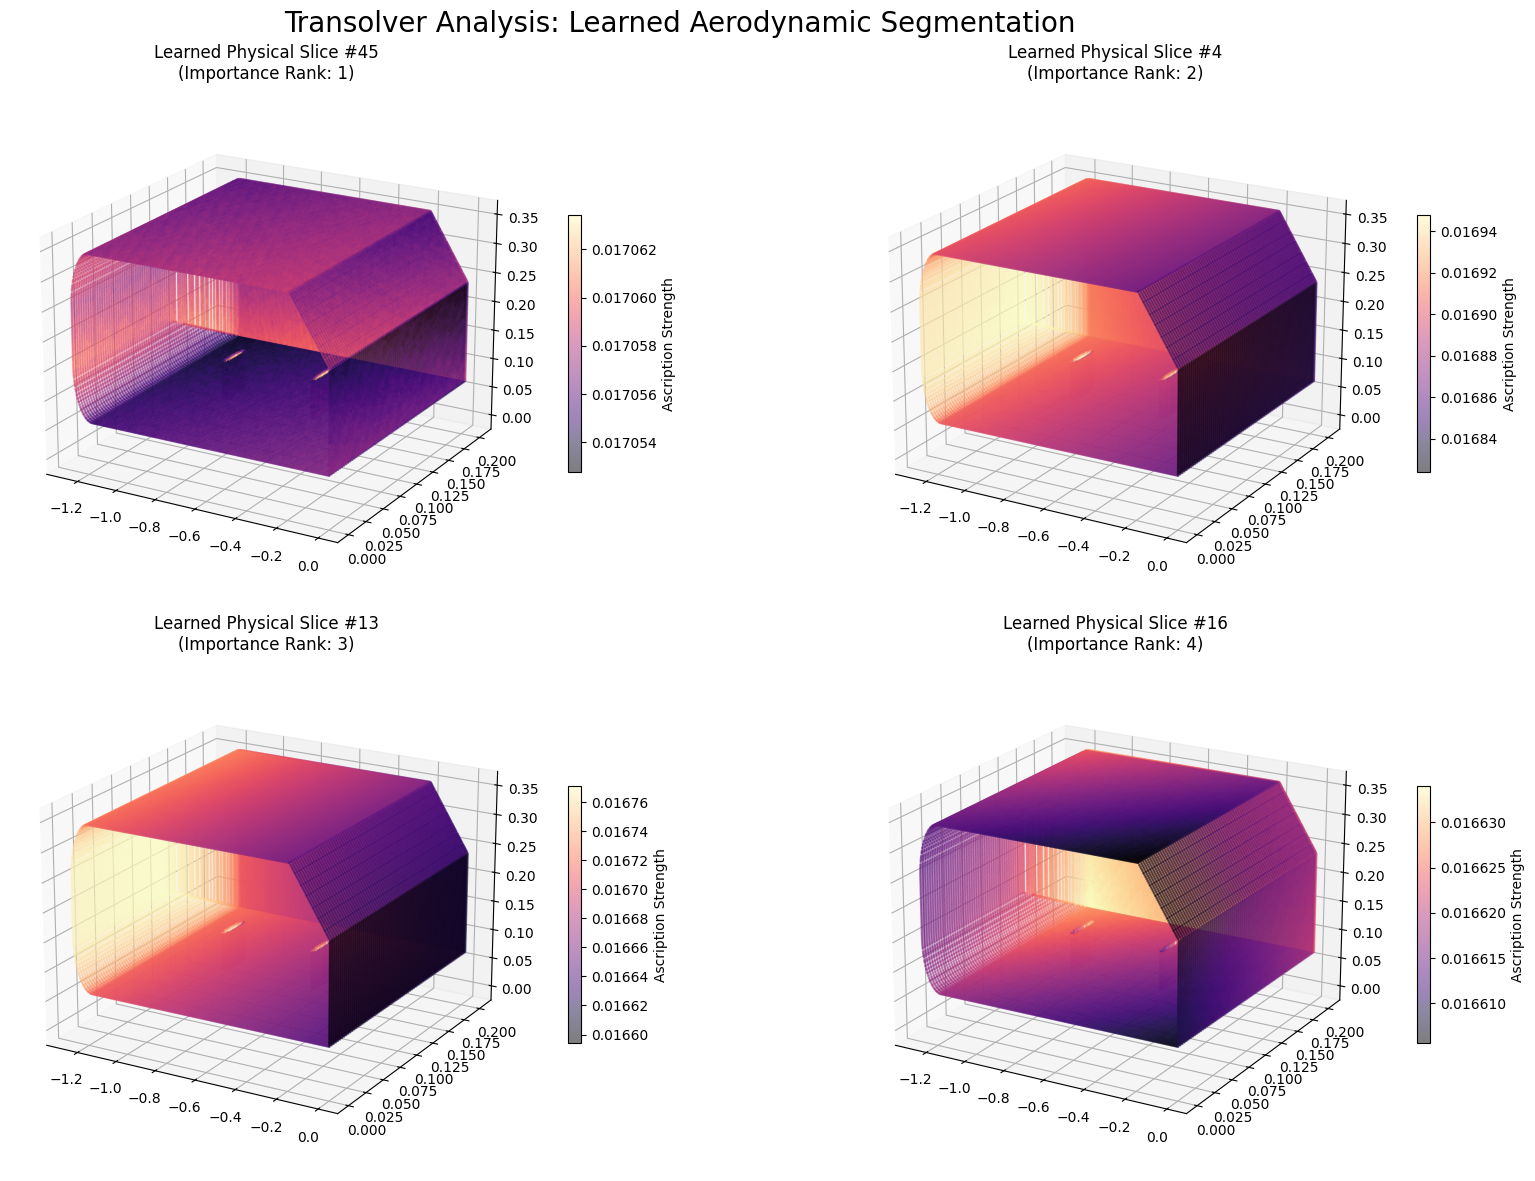

In [14]:
# ===============================================================
# VISUALIZING THE LEARNED SLICES (ASCRIPTION WEIGHTS)
# ===============================================================

import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Preparation ---
attn_layer = model.blocks[0].Attn
device = dist_manager.device
model.eval()

# --- 2. Dynamic Discovery by Shape ---
slicing_submodule = None
# We look for the layer that projects the hidden state (64) to the slices (64)
# In your model summary, we see these are the dimensions being used.
for name, module in attn_layer.named_modules():
    # Check for anything that behaves like a Linear layer
    if hasattr(module, 'weight') and hasattr(module.weight, 'shape'):
        shape = module.weight.shape # (Out, In)
        # We look for the 64x64 projection
        if shape[0] == 64 and shape[1] == 64:
            slicing_submodule = module
            print(f"Found slicing projection layer: {name} (Shape: {list(shape)})")
            break

if slicing_submodule is None:
    print("!!! Critical Search: Listing all layers and shapes to find the 'Sorting Hat':")
    for name, module in attn_layer.named_modules():
        if hasattr(module, 'weight'): print(f" - {name}: {module.weight.shape}")
    raise AttributeError("Could not identify the slicing layer by shape.")

# --- 3. Process Validation Data ---
sample = val_dataset[0]

with torch.no_grad():
    def get_mesh_tensor(key):
        t = sample[key].to(device).to(torch.float32)
        if t.dim() == 2: t = t.unsqueeze(0)
        return t

    # A. Build the input (Physics=2 + Geometry=3 + Normals=3 = 8)
    coords_raw = get_mesh_tensor('surface_mesh_centers') 
    normals = get_mesh_tensor('surface_normals')        
    N_points = coords_raw.shape[1]

    # Global Physics Features
    density = sample['air_density'].to(device).to(torch.float32).view(1, 1, 1)
    velocity = sample['stream_velocity'].to(device).to(torch.float32).view(1, 1, 1)
    physics_feat = torch.cat([density, velocity], dim=-1).repeat(1, N_points, 1)

    # Combined input (1, N, 8)
    x_input = torch.cat([physics_feat, coords_raw, normals], dim=-1)
    
    # B. Model Preprocessing (The 8 -> 64 embedding)
    x_hidden = model.preprocess(x_input) 
    
    # C. Extract Ascription Weights
    ascription_logits = slicing_submodule(x_hidden) 
    ascription = F.softmax(ascription_logits, dim=-1)
    ascription = ascription.squeeze(0).cpu().numpy() 

# --- 4. 3D Visualization of the Ahmed Body ---
fig = plt.figure(figsize=(18, 12))
coords_np = coords_raw.squeeze(0).cpu().numpy()
slice_usage = ascription.sum(axis=0)
top_slices = np.argsort(slice_usage)[-4:][::-1] 

for i, slice_idx in enumerate(top_slices):
    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    weights = ascription[:, slice_idx]
    
    img = ax.scatter(coords_np[:, 0], coords_np[:, 1], coords_np[:, 2], 
                     c=weights, cmap='magma', s=1, alpha=0.5)
    
    ax.set_title(f"Learned Physical Slice #{slice_idx}\n(Importance Rank: {i+1})")
    ax.view_init(elev=20, azim=-60)
    fig.colorbar(img, ax=ax, shrink=0.5, label="Ascription Strength")

plt.suptitle("Transolver Analysis: Learned Aerodynamic Segmentation", fontsize=20)
plt.tight_layout()
plt.show()

---
## **Entropy Analysis — Quantifying and Mapping Model Uncertainty**

As established in the previous stage, a model at only 5 epochs often exhibits "High Entropy." To move from visual observation to a rigorous scientific metric, we calculate the **Shannon Entropy** of the ascription weights across the entire mesh.

### What is this analysis doing?
This stage measures the mathematical **certainty** of the model's internal physical mapping:

* **Shannon Entropy Calculation:** We evaluate how "spread out" the ascription weights are. If a point is assigned evenly to all 64 slices, entropy is at its maximum (**6.0 bits**), representing total uncertainty or a "Fog" state.
* **Model Certainty Score:** This percentage represents how far the model has moved from random guessing toward a focused physical commitment.
* **Spatial Mapping:** By plotting these values in 3D, we can see exactly which parts of the Ahmed Body the model "understands" and which parts it is "confused" by.


--- Slicing Entropy Analysis ---
Mean Entropy: 5.9988 bits (Max possible: 6.0)
Model Certainty: 0.02%

CONCLUSION: The model is currently in a 'High Entropy' state.
It is treating every mesh point as a generic average of all physics.


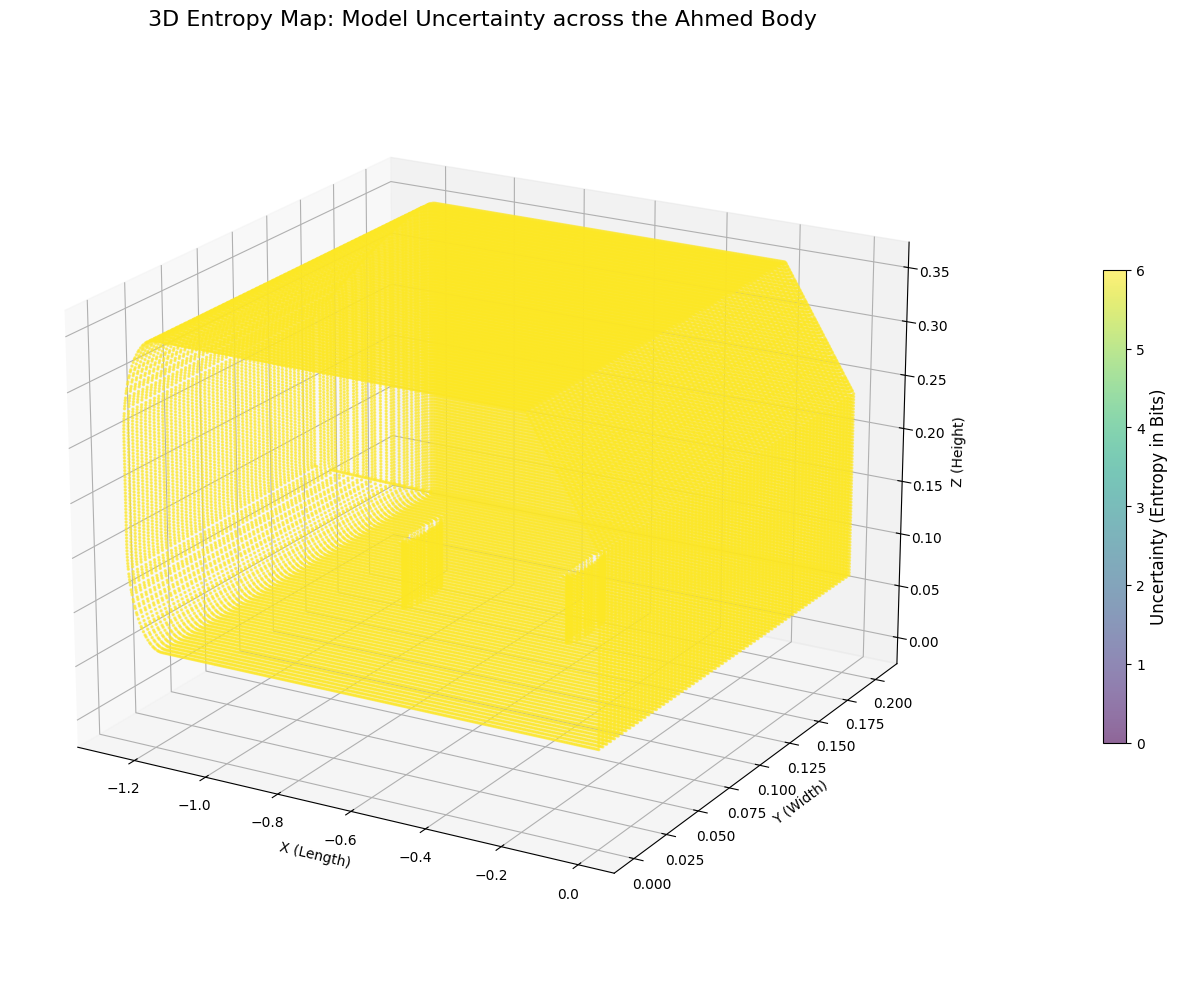

In [17]:
# ===============================================================
# ENTROPY ANALYSIS & 3D MAP VISUALIZATION
# ===============================================================

import matplotlib.pyplot as plt
import numpy as np

# 1. Calculate Shannon Entropy (Quantifying the "Fog")
# Formula: H = -sum(p * log2(p))
epsilon = 1e-9 # Prevent log(0)
entropy_per_node = -np.sum(ascription * np.log2(ascription + epsilon), axis=1)

# 2. Calculate Global Metrics
max_entropy = np.log2(64) # Max uncertainty for 64 slices is 6.0
mean_entropy = np.mean(entropy_per_node)
certainty_score = (1 - (mean_entropy / max_entropy)) * 100

print(f"--- Slicing Entropy Analysis ---")
print(f"Mean Entropy: {mean_entropy:.4f} bits (Max possible: {max_entropy:.1f})")
print(f"Model Certainty: {certainty_score:.2f}%")

if certainty_score < 5.0:
    print("\nCONCLUSION: The model is currently in a 'High Entropy' state.")
    print("It is treating every mesh point as a generic average of all physics.")
else:
    print("\nCONCLUSION: The model is starting to 'Commit' to specific physical states.")

# 3. 3D Entropy Map Plotting
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot: High entropy (6.0) = Dark/Purple | Low entropy (0.0) = Bright/Yellow
# We use 'viridis' as it is perceptually uniform for scientific data
img = ax.scatter(coords_np[:, 0], coords_np[:, 1], coords_np[:, 2], 
                 c=entropy_per_node, cmap='viridis', s=2, alpha=0.6,
                 vmin=0, vmax=6.0)

# Formatting the plot
ax.set_title("3D Entropy Map: Model Uncertainty across the Ahmed Body", fontsize=16)
ax.set_xlabel("X (Length)")
ax.set_ylabel("Y (Width)")
ax.set_zlabel("Z (Height)")

# Add Colorbar for interpretation
cbar = fig.colorbar(img, ax=ax, shrink=0.5, pad=0.1)
cbar.set_label('Uncertainty (Entropy in Bits)', fontsize=12)

# Set view focused on the rear slant and side profile
ax.view_init(elev=20, azim=-60)

plt.tight_layout()
plt.show()


### Figure Explanation: Understanding the Results
By running this analysis, you can diagnose the maturity of your training run:

1.  **Baseline Diagnostic:** An entropy value near **5.99** (Certainty $\approx 0.02\%$) confirms that the model is in its infancy. It has initialized its parameters but has not yet "broken symmetry" to identify specific geometric features like the rear slant or nose.
2.  **The Phase Transition:** As you increase training epochs, you should watch this number drop. A decrease in entropy is a leading indicator that the model is about to "pop" into a state where it can predict sharp pressure gradients accurately.



> **Key Takeaway:** This metric explains **why** the validation loss may still be high. If the Entropy is high, the model is still viewing the car as a single "blurry" block. To achieve high-fidelity predictions, the model must first lower its entropy and "commit" to specific physical states across the mesh surface.
